In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = "CS231n"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/CS231n


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tqdm as tqdm
import Utils

import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.regularizers import l2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy

In [4]:
def load_data(surface_path, target_path):
    targets = pd.read_csv(target_path, skiprows=2, parse_dates=True, index_col=0)
    targets = pd.DataFrame(targets['Close'])

    surfaces = pd.read_csv(surface_path, parse_dates=True, index_col=[0,1])

    dates = surfaces.index.get_level_values(0).unique()
    dates = pd.Series(list(set(targets.index).intersection(set(dates))))
    dates = dates.sort_values()


    targets = targets.loc[dates]
    surfaces = surfaces.loc[dates]
    return surfaces, targets

def target_volatility(surfaces, targets):
    rets = Utils.convert_to_daily_returns(targets)
    volatility = rets.rolling(window=60).std()*np.sqrt(252)
    dates = volatility.dropna().index
    return surfaces.loc[dates], volatility.dropna()


def stack_days(surfaces, targets, stacks):

    dim = len(surfaces.index.get_level_values(0).unique())
    dim1 = len(surfaces.index.get_level_values(1).unique())

    surfaces_np = surfaces.values.reshape((dim, dim1, surfaces.shape[1]))

    stacked_surfaces = np.zeros((len(surfaces_np)-stacks, dim1, surfaces.shape[1], stacks))
    
    for i in range(len(surfaces_np)-stacks):
        temp = np.stack(surfaces_np[i:i+stacks]).transpose(1,2,0)
        stacked_surfaces[i] = temp

    stacked_dates = surfaces.index.get_level_values(0).unique()[stacks:]
    
    return stacked_surfaces, targets.loc[stacked_dates], stacked_dates


def lag_targets(surfaces, targets, lag, dates):
    lagged = targets.shift(-lag)
    return surfaces[:-lag], lagged.dropna(), dates[lag:]


def train_test_split(test_start, test_end, dates, surfaces, targets):
    test_dates = pd.Series(dates, index=dates)[test_start:test_end]
    
    start_ind = dates.get_loc(test_dates.iloc[0])
    end_ind = dates.get_loc(test_dates.iloc[-1]) + 1
        
    surfaces_test = surfaces[start_ind:end_ind]
    targets_test = targets.to_numpy()[start_ind:end_ind]
    
    surfaces_train = surfaces[:start_ind]
    surfaces_train = np.concatenate((surfaces_train,surfaces[end_ind:]))

    targets_train = targets.to_numpy()[:start_ind]
    targets_train = np.concatenate((targets_train,targets.to_numpy()[end_ind:]))
    
    train_dates = pd.Series(dates, index=dates).loc[~pd.Series(dates, index=dates).index.isin(test_dates)].index
    
    return surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates
    
    
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [5]:
surfaces, targets = load_data("processed_data/SPX.csv", "data/VIX.csv")
stacked_surfaces, stacked_targets, dates = stack_days(surfaces, targets, 20)
stacked_surfaces, stacked_targets_lagged, dates = lag_targets(stacked_surfaces, stacked_targets, 20, dates)
surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates = train_test_split(
    '2019', '2023', dates, stacked_surfaces, stacked_targets_lagged)

In [7]:
input_shape = *surfaces_train[0].shape, 1
input_shape

(34, 11, 20, 1)

In [8]:
model = keras.models.Sequential()

model.add(layers.Conv3D(32, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(64, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.Conv3D(128, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(256, (3, 3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))


#model.add(layers.BatchNormalization())


model.add(layers.Flatten())

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(128, kernel_regularizer=l2(0.0005), activation='relu'))
#model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(),
              metrics=[r_square, tf.keras.losses.Huber()])

K.set_value(model.optimizer.learning_rate, 0.005)

history = model.fit(surfaces_train, targets_train, epochs=50, batch_size=64)

Epoch 1/50
90/90 [==============================] - 16s 44ms/step - loss: 7.7184 - r_square: -1.4099 - huber_loss: 7.5397
Epoch 2/50
90/90 [==============================] - 4s 41ms/step - loss: 3.5641 - r_square: 0.5240 - huber_loss: 3.4478
Epoch 3/50
90/90 [==============================] - 4s 43ms/step - loss: 3.6461 - r_square: 0.5052 - huber_loss: 3.5412
Epoch 4/50
90/90 [==============================] - 4s 41ms/step - loss: 3.4415 - r_square: 0.5509 - huber_loss: 3.3489
Epoch 5/50
90/90 [==============================] - 4s 42ms/step - loss: 3.2540 - r_square: 0.5863 - huber_loss: 3.1641
Epoch 6/50
90/90 [==============================] - 4s 41ms/step - loss: 3.1922 - r_square: 0.6007 - huber_loss: 3.1102
Epoch 7/50
90/90 [==============================] - 4s 41ms/step - loss: 3.3957 - r_square: 0.5682 - huber_loss: 3.3139
Epoch 8/50
90/90 [==============================] - 4s 42ms/step - loss: 3.0350 - r_square: 0.6239 - huber_loss: 2.9594
Epoch 9/50
90/90 [====================

24/24 - 1s - loss: 4.1830 - r_square: -2.1278e+00 - huber_loss: 4.0485 - 710ms/epoch - 30ms/step


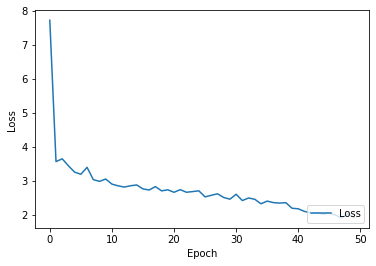

In [10]:
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss = model.evaluate(surfaces_test,  targets_test, verbose=2)

In [11]:
def plot_train_fit(surfaces_train, targets_train, dates_train):
        
    preds = model.predict(surfaces_train)
    print('R2: ')
    print(r2_score(targets_train, preds))
    print()
    
    print('MSE: ')
    print(mean_squared_error(targets_train, preds))
    print()
    
    test = pd.DataFrame(columns=['preds', 'targets'], index=dates_train)
    test['preds'] = preds
    test['targets'] = targets_train
    
    print('Corr: ')
    print(test.corr().iloc[0,1])
    print()
    
    print('Mean Absolute Error: ')
    print(np.abs(preds - targets_train).mean())
    print()
    
    print('Stdev Absolute Error: ')
    print(np.abs(preds - targets_train).std())
    print()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    plt.plot(dates_train, targets_train, label='Realized')
    plt.plot(dates_train, preds, label='Model')
    plt.legend()

R2: 
0.8456905224412405

MSE: 
11.690370675698757

Corr: 
0.9330813175869578

Mean Absolute Error: 
2.0311817437028488

Stdev Absolute Error: 
2.750394771618615



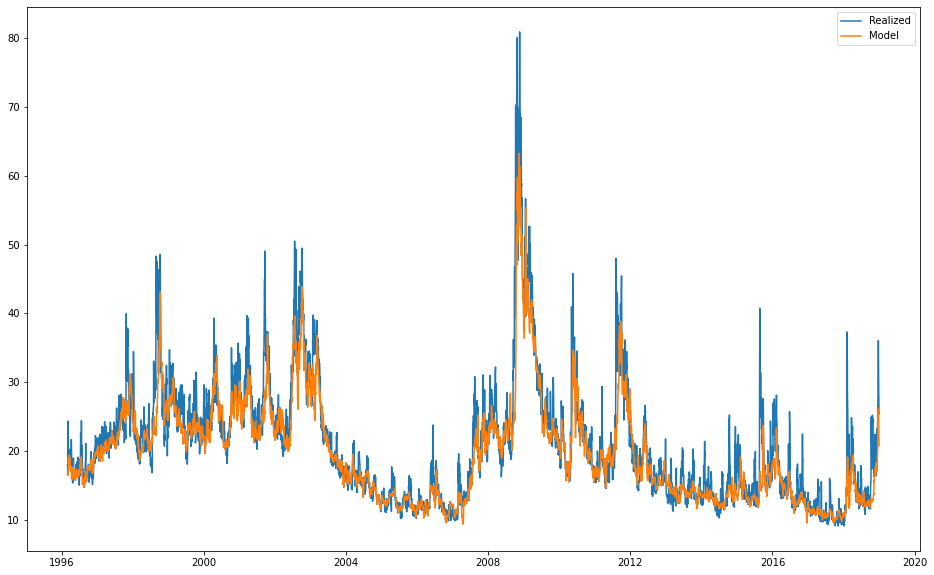

In [12]:
plot_train_fit(surfaces_train, targets_train, train_dates)